In [16]:
import sys
import os
import numpy as np
import pandas as pd
import re

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.utils import class_weight, shuffle
from collections import Counter

from torchvision import transforms

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import LinearCyclicalScheduler, CosineAnnealingScheduler

import random

from loader import ImageDS

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from efficientnet_pytorch import EfficientNet, utils as enet_utils

import warnings
warnings.filterwarnings('ignore')

SEED = 77

### Load data

In [17]:
df_train = pd.read_csv('/storage/aptosplus/trainLabels_smallds.csv')
df_valid = pd.read_csv('/storage/aptosplus/validLabels_smallds.csv')

train_x = df_train[['id_code', 'ds']]
train_y = df_train['diagnosis']

valid_x = df_valid[['id_code', 'ds']]
valid_y = df_valid['diagnosis']

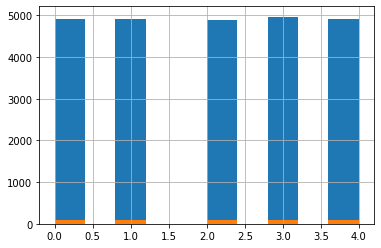

In [18]:
train_y.hist()
valid_y.hist()

In [19]:
valid_labels_count = Counter()

for i in valid_y:
    valid_labels_count.update([i])

valid_labels_count

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100})

In [20]:
train_labels_count = Counter()

for i in train_y:
    train_labels_count.update([i])

train_labels_count

Counter({2.0: 4899, 4.0: 4903, 1.0: 4913, 0.0: 4905, 3.0: 4966})

In [21]:
batch_size=16
model_name = 'efficientnet-b1'
num_classes = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# pytorch training dataset & loader
ds = ImageDS(train_x, train_y)
loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

# pytorch cross-validation dataset & loader
ds_val = ImageDS(valid_x, valid_y)
val_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=8)

### Model

In [23]:
model = EfficientNet.from_name(model_name) 

In [24]:
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-4, momentum=0.9)

metrics = {
    'loss': Loss(criterion)
}

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    lr = 10e-4

    if epoch < 80:
        lr = 10e-4
    elif epoch < 150:
        lr = 10e-5
    elif epoch < 190:
        lr = 50e-6
    else:
        lr = 10e-6

    print(f'\nLearning rate of epoch {epoch + 1}: {lr}\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    adjust_learning_rate(optimizer, engine.state.epoch)
    lr = float(optimizer.param_groups[0]['lr'])

In [27]:
def get_saved_model_path(epoch):
    return f'/storage/Model_{model_name}_{epoch}.pth'

best_loss = 100.
best_epoch = 1
best_epoch_file = ''

@trainer.on(Events.EPOCH_COMPLETED)
def save_best_epoch_only(engine):
    epoch = engine.state.epoch

    global best_loss
    global best_epoch
    global best_epoch_file
    best_loss = 100. if epoch == 1 else best_loss
    best_epoch = 1 if epoch == 1 else best_epoch
    best_epoch_file = '' if epoch == 1 else best_epoch_file

    metrics = val_evaluator.run(val_loader).metrics

    print(f'\nLoss for epoch {epoch}: {metrics["loss"]}\n')
    if metrics['loss'] < best_loss:
        prev_best_epoch_file = get_saved_model_path(best_epoch)
        if os.path.exists(prev_best_epoch_file):
            os.remove(prev_best_epoch_file)
            
        best_loss = metrics['loss']
        best_epoch = epoch
        best_epoch_file = get_saved_model_path(best_epoch)
        print(f'\nEpoch: {best_epoch} - New best loss! Loss: {best_loss}\n\n\n')
        torch.save(model.state_dict(), best_epoch_file)

In [28]:
scheduler = CosineAnnealingScheduler(optimizer, 'lr', 10e-4, 10e-6, len(loader))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

In [29]:
pbar = ProgressBar(bar_format='')
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [ ]:
print('Training started')
trainer.run(loader, max_epochs=150)

Training started



Learning rate of epoch 2: 0.001


Loss for epoch 1: 2.0094488582611083


Epoch: 1 - New best loss! Loss: 2.0094488582611083



